# Ordered Categories

## Trolley Problem
Action: harm caused by action is morally worse than equivalent harm caused by omission.
  
Intention: harm intended as the means to a goal is morally worse than equivalent harm foreseen as the side effect of a goal.  

Contact: using physical contact to cause harm to a vitim is morally worse than causing equivalent harm to a victim without using physical contact.  

## Estimand: How do action, intention, contact influence response to a trolley story?
![](img/fig10.1.png)

## Ordered = Cumulative  

${\rm Pr}(R_i = k) = {\rm Pr}(R_i \leq k) - {\rm Pr}(R_i \leq k - 1)$,  

${\rm log}\frac{{\rm Pr}(R_i \leq k)}{1 - {\rm Pr}(R_i \leq k)} = \alpha_k$ (cutpoint to estimate)  

## Generalized Linear Model (GLM)  

$\phi_i = \beta x_i$,  

${\rm log}\frac{{\rm Pr}(R_i \leq k)}{1 - {\rm Pr}(R_i \leq k)} = \alpha_k + \phi_i$.  

$R_i \sim OrderedLogit(\phi_i, alpha)$,  

$\phi_i = \beta_A A_i + \beta_C C_i + \beta_I I_i$,  

$\beta \sim Normal(0, 0.5)$,  

$\alpha \sim Normal(0, 0.5)$.

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('data/Trolley.csv', sep=";", header=0)
df

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9925,ilpon,3,23,98;299,66,1,Graduate Degree,0,1,0,pon,0
9926,ilsha,6,15,98;299,66,1,Graduate Degree,0,1,0,sha,0
9927,ilshi,7,7,98;299,66,1,Graduate Degree,0,1,0,shi,0
9928,ilswi,2,18,98;299,66,1,Graduate Degree,0,1,0,swi,0


In [3]:
# reindexing responses to values from 0 to 6 (0-based index)
R = df.response.values - 1

with pm.Model() as mRX:
    # cutpoints
    alpha = pm.Normal(name='alpha', mu=0, sigma=1, shape=6, testval=np.arange(6) -2.5)  # testval is the initial value
    bA = pm.Normal("bA", 0, 0.5)
    bC = pm.Normal("bC", 0, 0.5)
    bI = pm.Normal("bI", 0, 0.5)
    
    A = pm.MutableData("A", df.action.values)
    I = pm.MutableData("I", df.intention.values)
    C = pm.MutableData("C", df.contact.values)
    
    phi = pm.Deterministic("phi", bA * A + bC * C + bI * I)
    resp_obs = pm.OrderedLogistic("resp_obs", phi, alpha, observed=R)
    
    idata_RX = pm.sample()

C:\Users\84220\AppData\Local\Temp\ipykernel_23156\1437320428.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  alpha = pm.Normal(name='alpha', mu=0, sigma=1, shape=6, testval=np.arange(6) -2.5)  # testval is the initial value
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bA, bC, bI]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 561 seconds.


In [4]:
# az.plot_trace(idata_RX, var_names=['alpha', 'bA', 'bC', 'bI'], compact=True)
az.summary(idata_RX, var_names=['alpha', 'bA', 'bC', 'bI'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-2.82,0.05,-2.90,-2.73,0.0,0.0,1144.61,1901.17,1.0
alpha[1],-2.14,0.04,-2.22,-2.06,0.0,0.0,1047.14,1680.07,1.0
alpha[2],-1.56,0.04,-1.63,-1.48,0.0,0.0,998.78,1697.71,1.0
alpha[3],-0.54,0.04,-0.60,-0.47,0.0,0.0,1008.64,1489.71,1.0
alpha[4],0.13,0.04,0.06,0.20,0.0,0.0,1052.08,1580.83,1.0
alpha[5],1.04,0.04,0.96,1.11,0.0,0.0,1247.48,1851.27,1.0
bA,-0.69,0.04,-0.77,-0.62,0.0,0.0,1201.25,2123.43,1.0
bC,-0.94,0.05,-1.04,-0.86,0.0,0.0,1752.38,2528.58,1.0
bI,-0.71,0.04,-0.78,-0.64,0.0,0.0,1762.45,2337.26,1.0


In [5]:
cases_df = pd.DataFrame(np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]), columns=['action', 'contact', 'intention'])
cases_df

,action,contact,intention
0,0,0,0
1,0,0,1
2,1,0,0
3,1,0,1
4,0,1,0
5,0,1,1


## Posterior Predictive Simulation

In [6]:
row = cases_df.iloc[0]

with mRX:
    pm.set_data(
        {
            "A": np.repeat(
                row["action"],
                len(df.action)
            ),
            "C": np.repeat(
                row["contact"],
                len(df.contact)
            ),
            "I": np.repeat(
                row["intention"],
                len(df.intention)
            )
        }
    )
    post_pred = pm.sample_posterior_predictive(idata_RX, var_names=["resp_obs"])
    
pp_phi = az.extract(post_pred, group="posterior_predictive")["resp_obs"]

Sampling: [resp_obs]


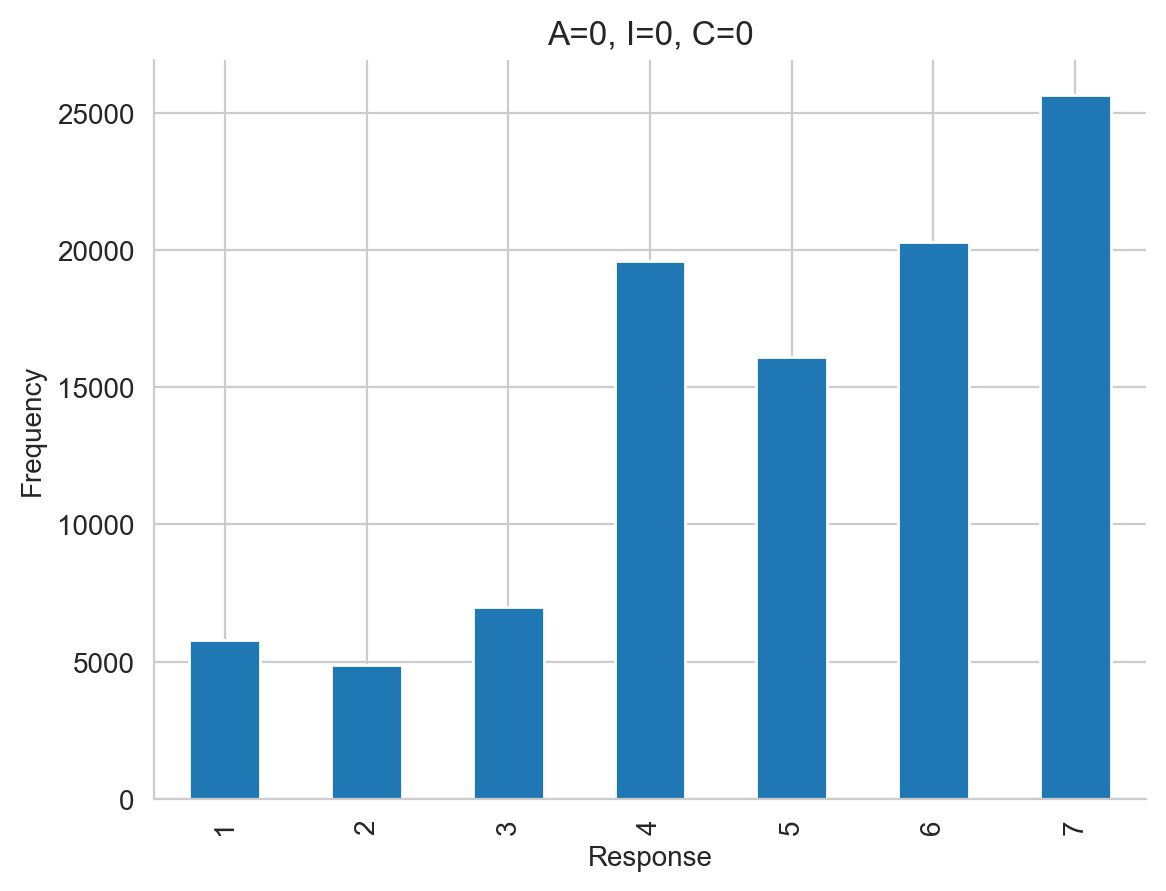

In [7]:
# adding 1 to convert back to orginal response values
ax = pd.Series(pp_phi[:,:10].values.flatten() + 1).value_counts().sort_index().plot(kind='bar')
ax.set_xlabel('Response')
ax.set_ylabel('Frequency')
ax.set_title("A={}, I={}, C={}".format(row["action"], row["intention"], row["contact"]))
sns.despine()

Sampling: [resp_obs]


Sampling: [resp_obs]


Sampling: [resp_obs]


Sampling: [resp_obs]


Sampling: [resp_obs]


Sampling: [resp_obs]


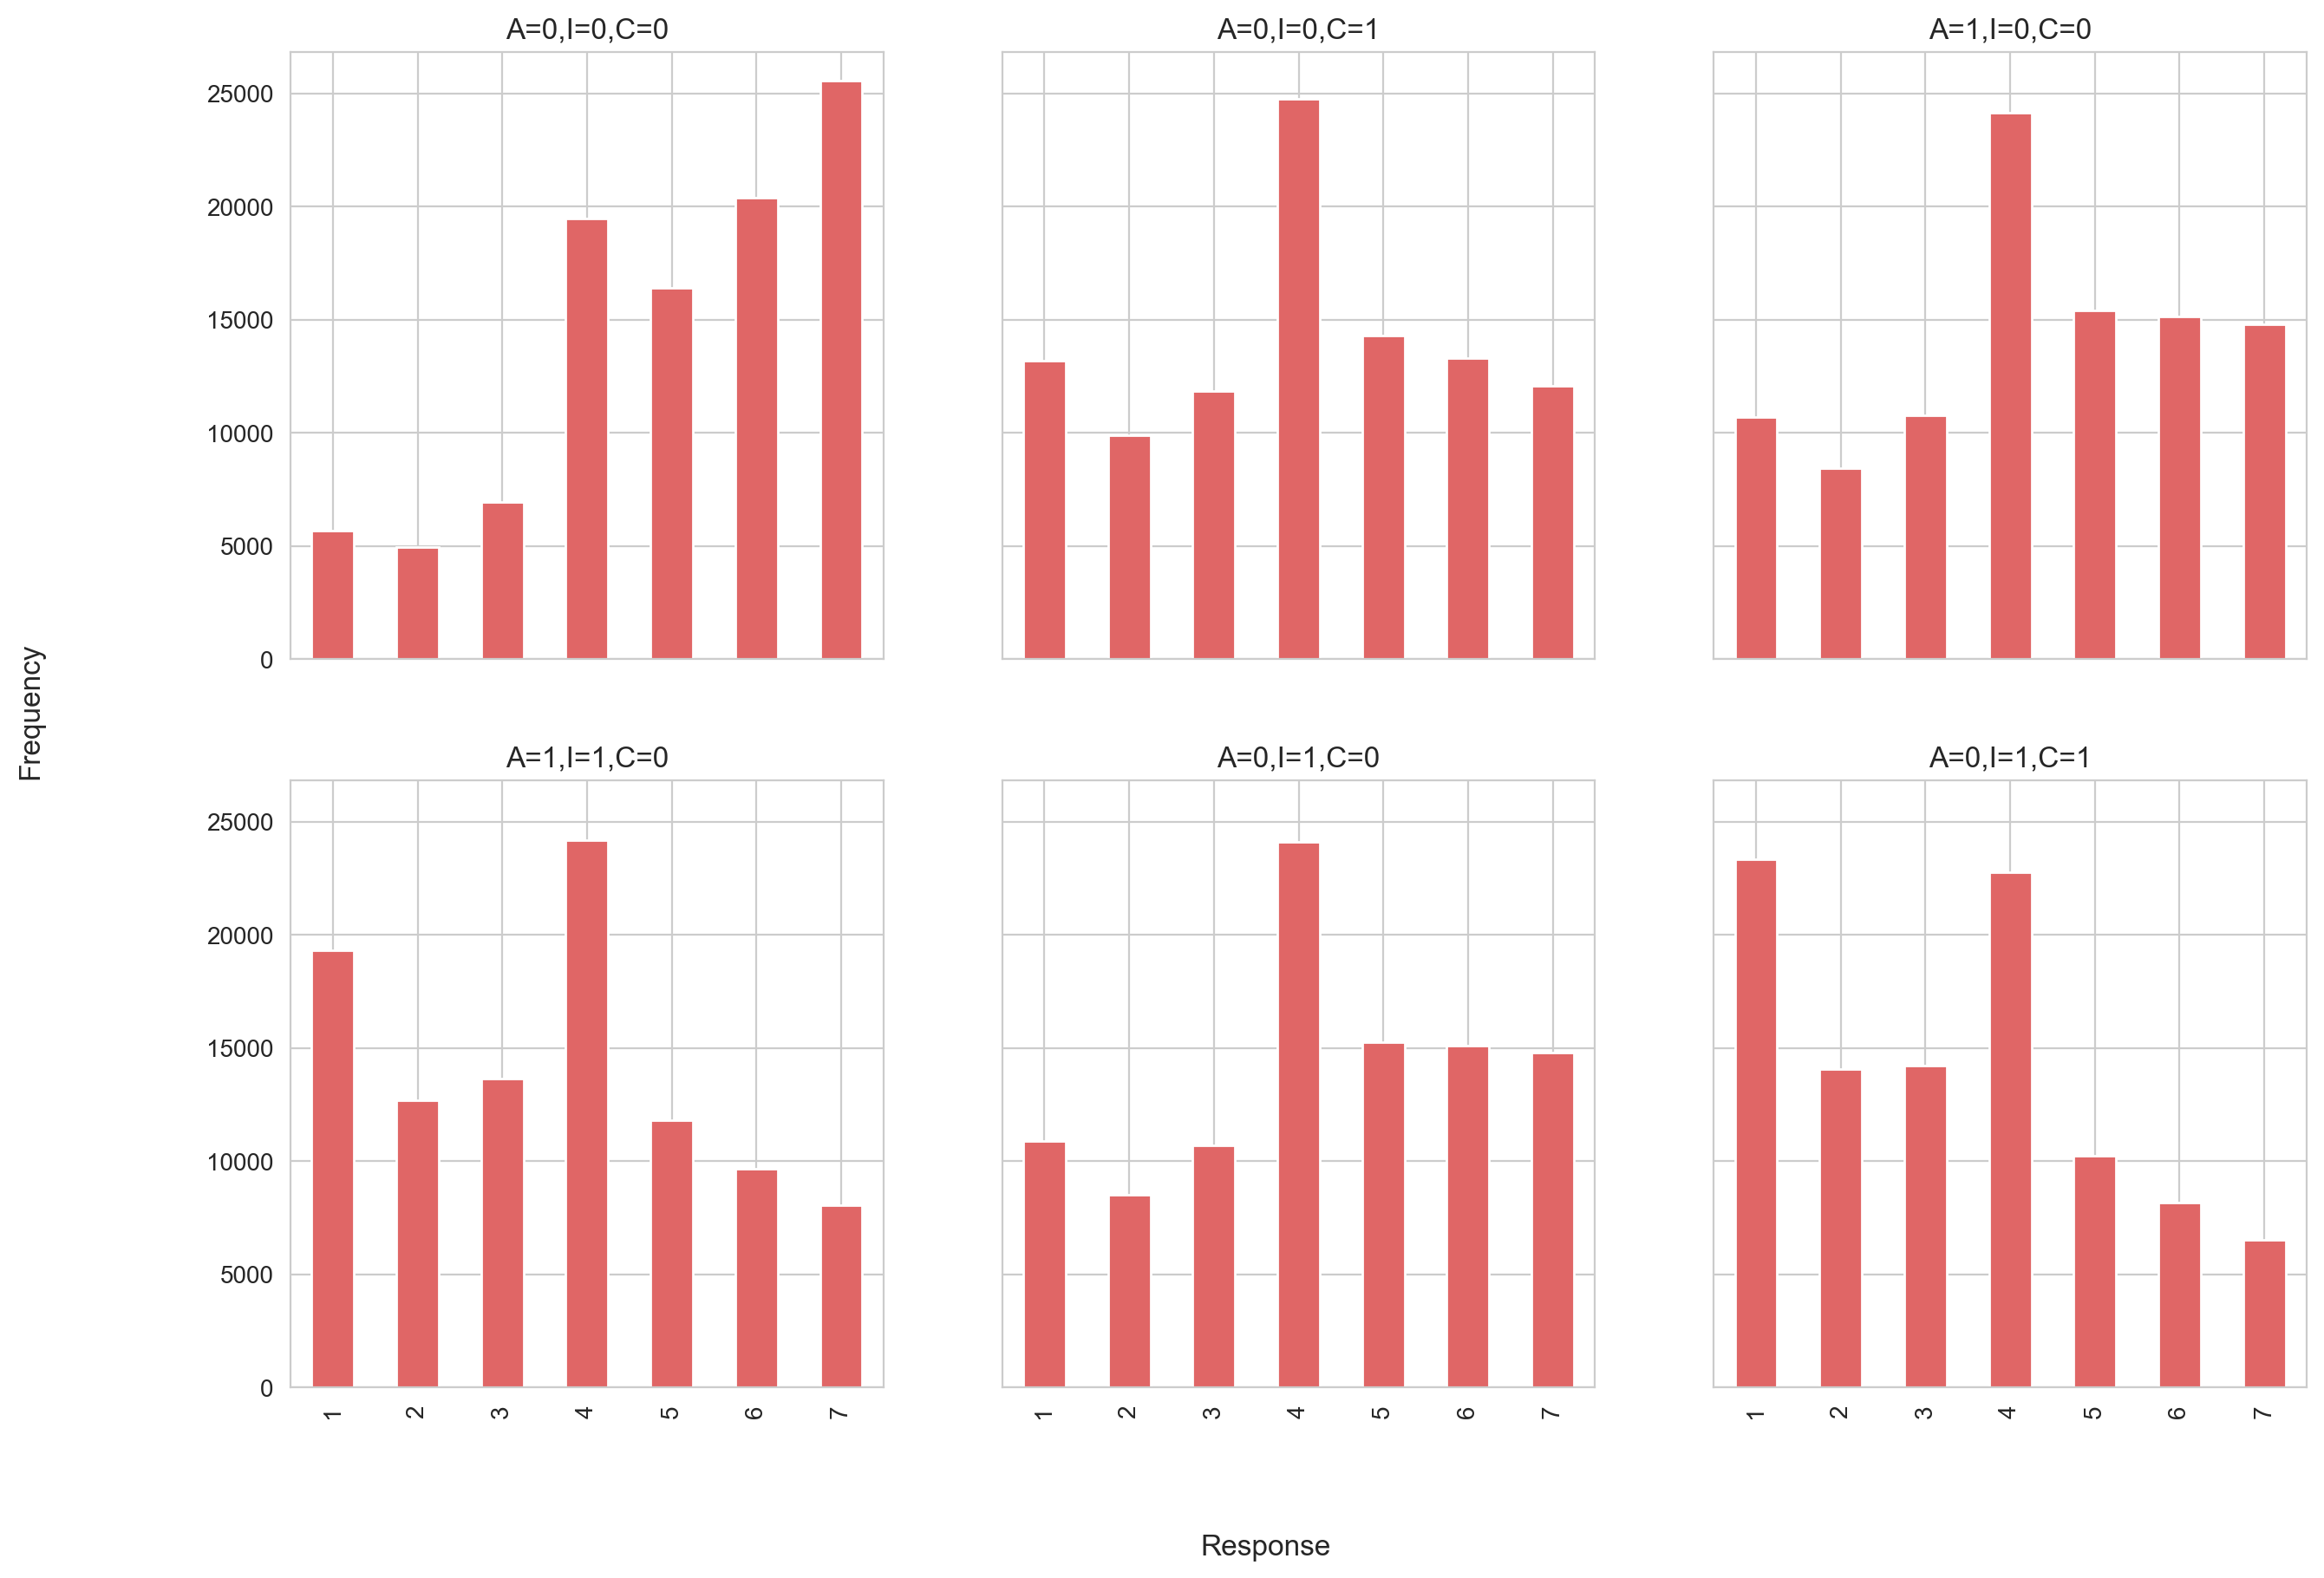

In [8]:
N_ROWS = 2
N_COLS = 3

#define subplot layout
fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, sharex=True, sharey=True, figsize=(15,10))

for i in range(len(cases_df)):
    row = cases_df.iloc[i]
    with mRX:
        pm.set_data(
            {
                "A": np.repeat(
                        row["action"], 
                        len(df.action)
                ),
                "C": np.repeat(
                        row["contact"], 
                        len(df.contact)
                ),
                "I": np.repeat(
                        row["intention"], 
                        len(df.intention)
                )
            }
        )
        post_pred = pm.sample_posterior_predictive(
                    idata_RX,
                    var_names=["resp_obs"],
        )
        
    pp_phi = az.extract(post_pred, group="posterior_predictive")["resp_obs"]
    
    #add distributions to subplots
    pd.Series(
            pp_phi[:, :10].values.flatten() + 1
    ).value_counts().sort_index().plot(
            kind="bar", 
            color="#e06666",
            ax=axes[i % N_ROWS, i % N_COLS]
    )
                
    _ = axes[i % N_ROWS, i % N_COLS].set_title(
            "A={},I={},C={}".format(
                    row["action"], 
                    row["intention"],
                    row["contact"]
            )
    )
    

_ = fig.supxlabel("Response")
_ = fig.supylabel("Frequency")

## Total Effect of Gender

$R_i \sim OrderedLogit(\phi_i, alpha)$,  

$\phi_i = \beta_{A, G[i]} A_i + \beta_{C, G[i]} C_i + \beta_{I, G[i]} I_i$,  

$\beta \sim Normal(0, 0.5)$,  

$\alpha \sim Normal(0, 0.5)$.

In [9]:
with pm.Model() as mRXG:
    # cutpoints
    alpha = pm.Normal(name='alpha', mu=0, sigma=1, shape=6, testval=np.arange(6) -2.5)  # testval is the initial value
    bA = pm.Normal("bA", 0, 0.5, shape=2)
    bC = pm.Normal("bC", 0, 0.5, shape=2)
    bI = pm.Normal("bI", 0, 0.5, shape=2)
    
    A = pm.MutableData("A", df.action.values)
    I = pm.MutableData("I", df.intention.values)
    C = pm.MutableData("C", df.contact.values)
    G = pm.MutableData("G", df.male.values)
    
    phi = pm.Deterministic("phi", bA[G] * A + bC[G] * C + bI[G] * I)
    resp_obs = pm.OrderedLogistic("resp_obs", phi, alpha, observed=R)
    
    idata_RXG = pm.sample()

C:\Users\84220\AppData\Local\Temp\ipykernel_23156\3976271332.py:3: FutureWarning: The `testval` argument is deprecated; use `initval`.
  alpha = pm.Normal(name='alpha', mu=0, sigma=1, shape=6, testval=np.arange(6) -2.5)  # testval is the initial value
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bA, bC, bI]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 470 seconds.


In [10]:
az.summary(idata_RXG, var_names=["bC", "bI", "bA", "alpha"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bC[0],-1.06,0.07,-1.18,-0.93,0.0,0.0,2114.95,2561.87,1.00
bC[1],-0.84,0.06,-0.96,-0.73,0.0,0.0,2206.94,2962.80,1.00
bI[0],-0.90,0.05,-0.99,-0.80,0.0,0.0,2053.73,1994.19,1.00
bI[1],-0.55,0.05,-0.64,-0.47,0.0,0.0,2100.45,2882.99,1.00
bA[0],-0.88,0.05,-0.98,-0.79,0.0,0.0,1664.80,2486.50,1.00
bA[1],-0.53,0.05,-0.62,-0.44,0.0,0.0,1539.83,1881.22,1.00
alpha[0],-2.83,0.05,-2.92,-2.74,0.0,0.0,939.36,1572.45,1.00
alpha[1],-2.15,0.04,-2.23,-2.07,0.0,0.0,816.17,1401.86,1.01
alpha[2],-1.56,0.04,-1.64,-1.49,0.0,0.0,839.69,1267.67,1.00
alpha[3],-0.53,0.04,-0.60,-0.46,0.0,0.0,856.70,1303.67,1.01


In [11]:
cases_df = pd.DataFrame(
    np.array([[0, 1, 1, 0], [0, 1, 1, 1]]), 
    columns=["action", "contact", "intention", "gender"], 
)
cases_df

,action,contact,intention,gender
0,0,1,1,0
1,0,1,1,1


Sampling: [resp_obs]


Sampling: [resp_obs]


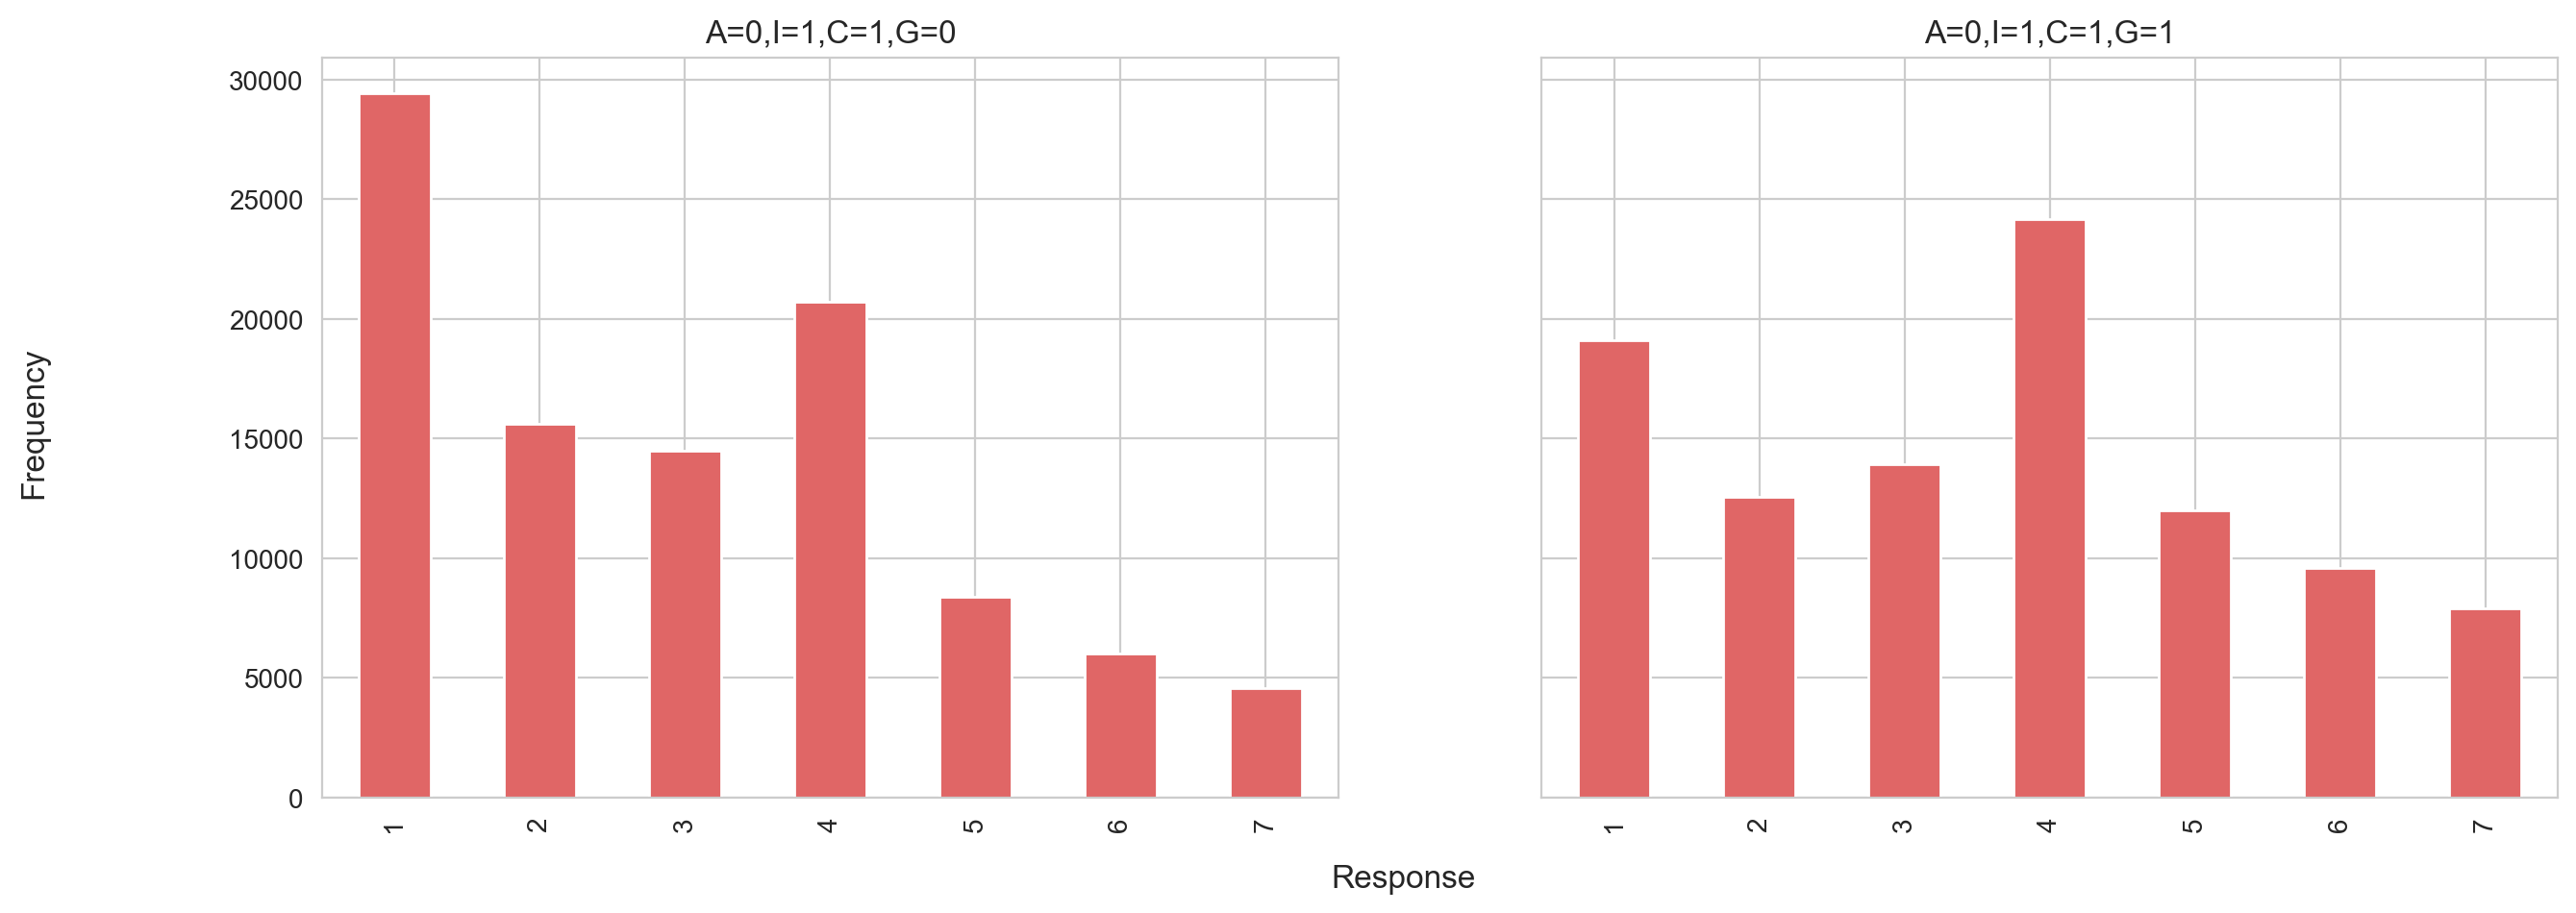

In [12]:
N_ROWS = 1
N_COLS = 2
#define subplot layout
fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, sharex=True, sharey=True, figsize=(15,5))

for i in range(len(cases_df)):
    row = cases_df.iloc[i]
    with mRXG:
        pm.set_data(
            {
                "A": np.repeat(
                        row["action"], 
                        len(df.action)
                ),
                "C": np.repeat(
                        row["contact"], 
                        len(df.contact)
                ),
                "I": np.repeat(
                        row["intention"], 
                        len(df.intention)
                ),
                "G": np.repeat(
                        row["gender"],
                        len(df.male)
                )
                
            }
        )
        post_pred = pm.sample_posterior_predictive(
                    idata_RXG,
                    var_names=["resp_obs"], 
        )
        
    pp_phi = az.extract(post_pred, group="posterior_predictive")["resp_obs"]
    
    #add distributions to subplots
    pd.Series(
            pp_phi[:,:10].values.flatten() + 1
    ).value_counts().sort_index().plot(
            kind="bar", 
            color="#e06666",
            ax=axes[i % N_COLS]
    )
                
    _ = axes[i % N_COLS].set_title(
            "A={},I={},C={},G={}".format(
                    row["action"], 
                    row["intention"], 
                    row["contact"],
                    row["gender"]
            )
    )
    

_ = fig.supxlabel("Response")
_ = fig.supylabel("Frequency")

## Ordered Monotonic Predictors  

Education is an ordered category

In [13]:
# encoding education levels in proper order
df["edu_cat"] = pd.Categorical( 
    df.edu.values, 
    categories=[ 
        "Elementary School", 
        "Middle School", 
        "Some High School", 
        "High School Graduate", 
        "Some College", 
        "Bachelor's Degree", 
        "Master's Degree", 
        "Graduate Degree", 
    ], 
    ordered=True, 
) 
df["edu_new"] = df.edu_cat.cat.codes

df

,case,response,order,id,age,male,edu,action,intention,contact,story,action2,edu_cat,edu_new
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1,Middle School,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1,Middle School,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1,Middle School,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1,Middle School,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1,Middle School,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9925,ilpon,3,23,98;299,66,1,Graduate Degree,0,1,0,pon,0,Graduate Degree,7
9926,ilsha,6,15,98;299,66,1,Graduate Degree,0,1,0,sha,0,Graduate Degree,7
9927,ilshi,7,7,98;299,66,1,Graduate Degree,0,1,0,shi,0,Graduate Degree,7
9928,ilswi,2,18,98;299,66,1,Graduate Degree,0,1,0,swi,0,Graduate Degree,7


$\phi_i = \beta_E \displaystyle\sum_{j=0}^{E_i - 1}\delta_j$,  

where $\beta_E$ is the maximum effect and $\delta_j$ is the proportion of maximum effect ($\delta_0 = 0$ and $\sum\delta_j = 1$).

$R_i \sim OrderedLogit(\phi_i, alpha)$,  

$\phi_i = \beta_E \displaystyle\sum_{j=0}^{E_i - 1}\delta_j + \beta_{A} A_i + \beta_{C} C_i + \beta_{I} I_i$,  

$\beta \sim Normal(0, 0.5)$,  

$\alpha \sim Normal(0, 0.5)$,

$\delta_j \sim Dirichlet([2, 2, 2, 2, 2, 2, ...])$.

Text(0.5, 1.0, ' smaller α values: more variation')

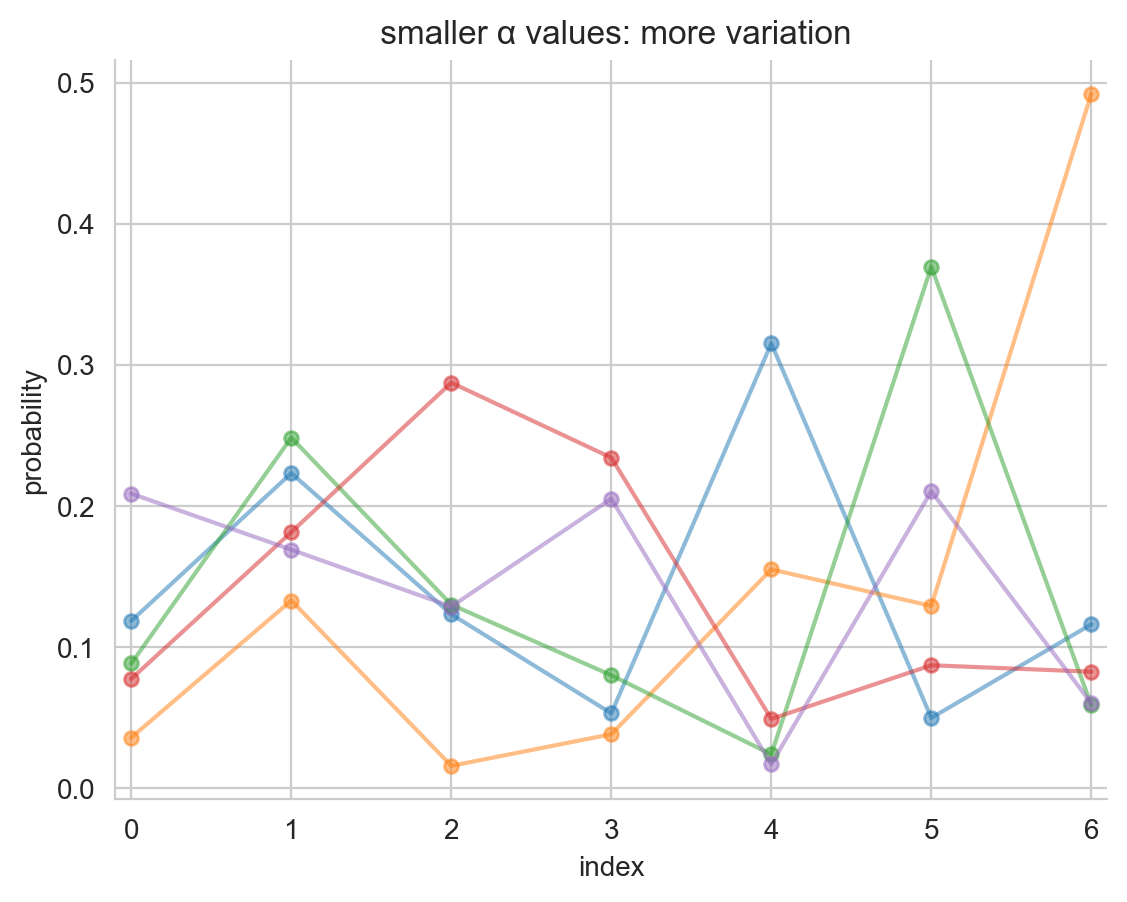

In [14]:
# simulate from Dirichlet([2,2,2,2,2,2,2])
N = 1000
DIST_DIMS = 7
alphas1 = np.repeat(2, DIST_DIMS)
prior_sim1 = stats.dirichlet.rvs(alphas1, size=N)

for i in range(5):
    plt.plot(range(DIST_DIMS), prior_sim1[i], marker='o', markersize=5, alpha=0.5)

plt.xlim([-0.1,6.1])
plt.ylabel("probability")
plt.xlabel("index")
sns.despine()
plt.title(" smaller α values: more variation")

Text(0.5, 1.0, 'larger α values: less variation')

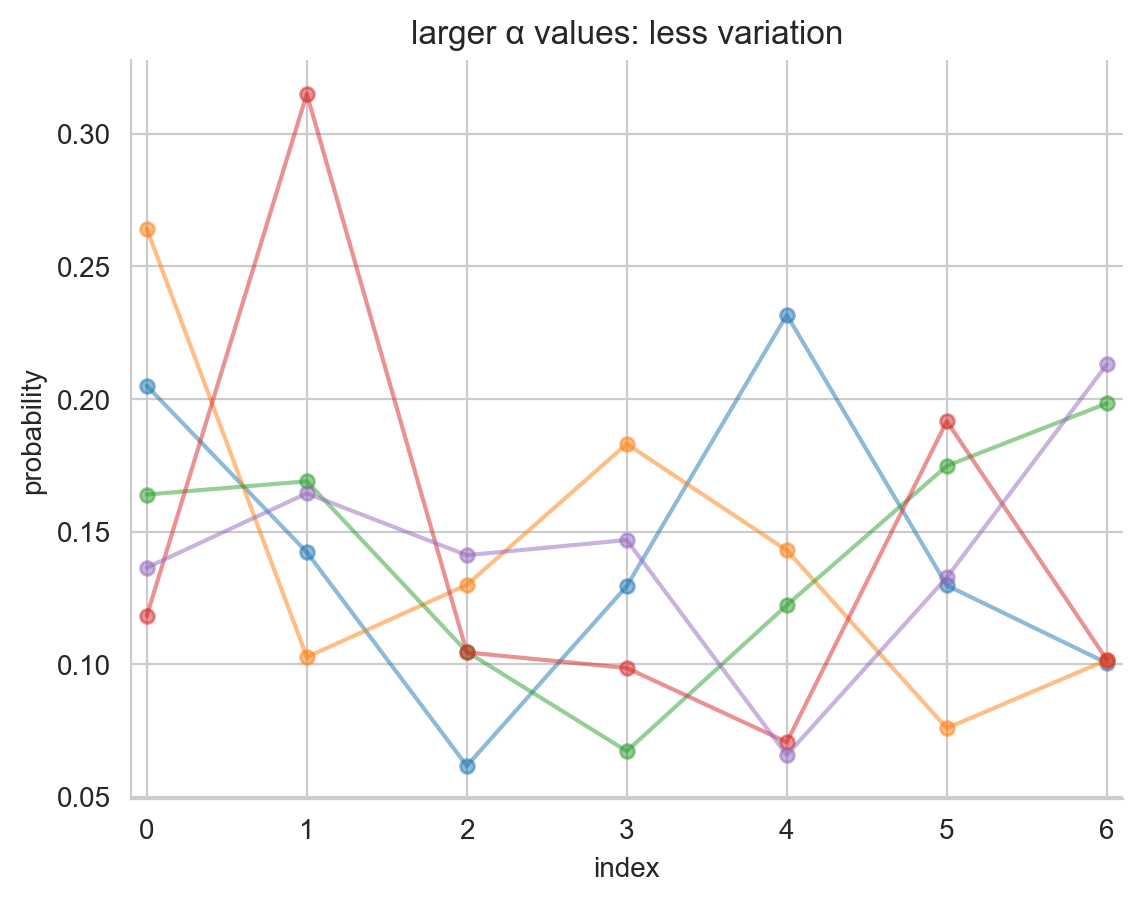

In [15]:
N = 1000
DIST_DIMS = 7
alphas1 = np.repeat(10, DIST_DIMS)
prior_sim1 = stats.dirichlet.rvs(alphas1, size=N)

for i in range(5):
    plt.plot(range(DIST_DIMS), prior_sim1[i], marker='o', markersize=5, alpha=0.5)

plt.xlim([-0.1,6.1])
plt.ylabel("probability")
plt.xlabel("index")
sns.despine()
plt.title("larger α values: less variation")

In [16]:
import pytensor.tensor as pt

R = df.response.values - 1
A = df.action.values
I = df.intention.values
C = df.contact.values
E = df.edu_new.values

with pm.Model() as mRXE:
    alpha = pm.Normal(
        "alpha",
        0.0,
        1,
        shape=6,
        testval=np.arange(6),
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)

    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = pt.concatenate([pt.zeros(1), delta])  # explicitly providing delta_0 = 0
    delta_j_cumulative = pt.extra_ops.cumsum(delta_j)

    phi = bE * delta_j_cumulative[E] + bA * A + bC * C + bI * I

    resp_obs = pm.OrderedLogistic("resp_obs", phi, alpha, observed=R)

    idata_RXE = pm.sample(2000, tune=2000)

C:\Users\84220\AppData\Local\Temp\ipykernel_23156\188480831.py:10: FutureWarning: The `testval` argument is deprecated; use `initval`.
  alpha = pm.Normal(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bA, bC, bI, bE, delta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2400 seconds.


In [17]:
az.summary(idata_RXE, var_names=["bC", "bI", "bA", "bE", "alpha", "delta"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bC,-0.94,0.05,-1.03,-0.85,0.0,0.0,6409.81,5981.03,1.0
bI,-0.71,0.04,-0.78,-0.64,0.0,0.0,7971.82,5820.66,1.0
bA,-0.69,0.04,-0.77,-0.62,0.0,0.0,6379.38,5859.27,1.0
bE,-0.22,0.15,-0.50,0.07,0.0,0.0,1291.80,1806.92,1.0
alpha[0],-2.98,0.13,-3.22,-2.74,0.0,0.0,1267.68,1796.97,1.0
alpha[1],-2.30,0.12,-2.55,-2.07,0.0,0.0,1246.42,1793.13,1.0
alpha[2],-1.72,0.12,-1.96,-1.49,0.0,0.0,1242.93,1737.39,1.0
alpha[3],-0.70,0.12,-0.95,-0.48,0.0,0.0,1230.96,1767.26,1.0
alpha[4],-0.03,0.12,-0.28,0.19,0.0,0.0,1228.13,1810.31,1.0
alpha[5],0.88,0.12,0.63,1.10,0.0,0.0,1245.55,1831.60,1.0


## Stratify by age and gender to block non-causal paths for influence of education  

$\beta_E$ is not interpretable causally, as we need to condition on age and gender for valid estimate (both are confounds that cause E and R to be statistically associated).  

$\phi_i = \beta_E \displaystyle\sum_{j=0}^{E_i - 1}\delta_j$,  

where $\beta_E$ is the maximum effect and $\delta_j$ is the proportion of maximum effect ($\delta_0 = 0$ and $\sum\delta_j = 1$).

$R_i \sim OrderedLogit(\phi_i, alpha)$,  

$\phi_i = \beta_E \displaystyle\sum_{j=0}^{E_i - 1}\delta_j + \beta_{A, G[i]} A_i + \beta_{C, G[i]} C_i + \beta_{I, G[i]} I_i + \beta_{Y, G[i]}Y_i$,  

$\beta \sim Normal(0, 0.5)$,  

$\alpha \sim Normal(0, 0.5)$,

$\delta_j \sim Dirichlet([2, 2, 2, 2, 2, 2, ...])$.

In [18]:
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

In [19]:
R = df.response.values - 1
A = df.action.values
I = df.intention.values
C = df.contact.values
E = df.edu_new.values
G = df.male.values # 0: female, 1: male
Y = standardize(df.age.values)

with pm.Model() as mRXEYGt:
    alpha = pm.Normal(
        "alpha",
        0.0,
        1,
        shape=6,
        testval=np.arange(6),
    )

    bA = pm.Normal("bA", 0.0, 0.5, shape=len(np.unique(G)))
    bC = pm.Normal("bC", 0.0, 0.5, shape=len(np.unique(G)))
    bI = pm.Normal("bI", 0.0, 0.5, shape=len(np.unique(G)))
    bE = pm.Normal("bE", 0.0, 0.5, shape=len(np.unique(G)))
    bY = pm.Normal("bY", 0.0, 0.5, shape=len(np.unique(G)))

    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = pt.concatenate([pt.zeros(1), delta])
    delta_j_cumulative = pt.extra_ops.cumsum(delta_j)

    phi = bE[G] * delta_j_cumulative[E] + bA[G] * A + bC[G] * C + bI[G] * I + bY[G] * Y

    resp_obs = pm.OrderedLogistic("resp_obs", phi, alpha, observed=R)

    idata_RXEYGt = pm.sample(2000, tune=2000)

C:\Users\84220\AppData\Local\Temp\ipykernel_23156\2795464931.py:10: FutureWarning: The `testval` argument is deprecated; use `initval`.
  alpha = pm.Normal(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bA, bC, bI, bE, bY, delta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2514 seconds.


In [20]:
az.summary(idata_RXEYGt, var_names=["bC", "bI", "bA", "bE", "bY", "alpha", "delta"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bC[0],-0.77,0.07,-0.90,-0.64,0.0,0.0,10551.49,6098.27,1.0
bC[1],-1.09,0.07,-1.22,-0.97,0.0,0.0,9428.97,6299.53,1.0
bI[0],-0.66,0.05,-0.76,-0.56,0.0,0.0,10667.55,5722.88,1.0
bI[1],-0.76,0.05,-0.85,-0.67,0.0,0.0,9093.23,5180.99,1.0
bA[0],-0.56,0.06,-0.67,-0.45,0.0,0.0,9135.58,6123.63,1.0
bA[1],-0.81,0.05,-0.90,-0.70,0.0,0.0,8510.68,6269.65,1.0
bE[0],-0.63,0.13,-0.89,-0.39,0.0,0.0,1751.38,2768.36,1.0
bE[1],0.41,0.13,0.16,0.64,0.0,0.0,1643.88,3054.14,1.0
bY[0],-0.00,0.03,-0.05,0.05,0.0,0.0,10702.22,5572.19,1.0
bY[1],-0.13,0.03,-0.19,-0.08,0.0,0.0,4697.36,5613.20,1.0
